## Import required libraries

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import findspark
findspark.init()

## Initialize Spark Session

In [6]:
from pyspark.sql import SparkSession

# Connect to your Spark cluster
spark = SparkSession.builder \
    .appName("JupyterSparkCluster") \
    .master("spark://192.168.250.109:7077") \
    .getOrCreate()

# Verify the Spark session
print(spark.version)

3.5.3


## Read the CSV file

In [7]:
# HDFS path to the CSV file
hdfs_path = "hdfs://localhost:9000/data/netflix/netflix_merged_summary.csv"

# Read the CSV file from HDFS
df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Show the first few rows
df.show()

# Print the schema of the DataFrame
df.printSchema()

+-------+--------------------+------+-------------+------------------+------------+
|MovieID|               Title|  Year|total_ratings|        avg_rating|unique_users|
+-------+--------------------+------+-------------+------------------+------------+
|      1|     Dinosaur Planet|2003.0|          547| 3.749542961608775|         547|
|      2|Isle of Man TT 20...|2004.0|          145|3.5586206896551724|         145|
|      3|           Character|1997.0|         2012|3.6411530815109345|        2012|
|      4|Paula Abdul's Get...|1994.0|          142|  2.73943661971831|         142|
|      5|The Rise and Fall...|2004.0|         1140|3.9192982456140353|        1140|
|      6|                Sick|1997.0|         1019| 3.084396467124632|        1019|
|      7|               8 Man|1992.0|           93| 2.129032258064516|          93|
|      8|What the #$*! Do ...|2004.0|        14910|3.1898054996646548|       14910|
|      9|Class of Nuke 'Em...|1991.0|           95|2.6210526315789475|      

In [8]:
print("Schema:")
df.printSchema()

Schema:
root
 |-- MovieID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- total_ratings: integer (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- unique_users: integer (nullable = true)



In [9]:
print("\nSample Data:")
df.show(5)



Sample Data:
+-------+--------------------+------+-------------+------------------+------------+
|MovieID|               Title|  Year|total_ratings|        avg_rating|unique_users|
+-------+--------------------+------+-------------+------------------+------------+
|      1|     Dinosaur Planet|2003.0|          547| 3.749542961608775|         547|
|      2|Isle of Man TT 20...|2004.0|          145|3.5586206896551724|         145|
|      3|           Character|1997.0|         2012|3.6411530815109345|        2012|
|      4|Paula Abdul's Get...|1994.0|          142|  2.73943661971831|         142|
|      5|The Rise and Fall...|2004.0|         1140|3.9192982456140353|        1140|
+-------+--------------------+------+-------------+------------------+------------+
only showing top 5 rows



In [10]:
# Show summary statistics
print("\nSummary Statistics:")
df.summary().show()



Summary Statistics:


24/11/28 22:36:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------------------+------------------+-----------------+------------------+-----------------+
|summary|           MovieID|               Title|              Year|    total_ratings|        avg_rating|     unique_users|
+-------+------------------+--------------------+------------------+-----------------+------------------+-----------------+
|  count|             17763|               17763|             17763|            17763|             17763|            17763|
|   mean| 8884.640376062602|            Infinity|1990.2636941958003|5656.676349715701|3.2283285258074916|5656.676349715701|
| stddev|5129.6470477088715|                 NaN|16.507890952762736|16912.65024708299|0.5260540787572019|16912.65024708299|
|    min|                 1|"Brazil: The ""Lo...|            1896.0|                3|1.2878787878787878|                3|
|    25%|              4442|                20.0|            1985.0|              192|2.8976377952755907|              192|
|    50%

## Distribution of Average Ratings

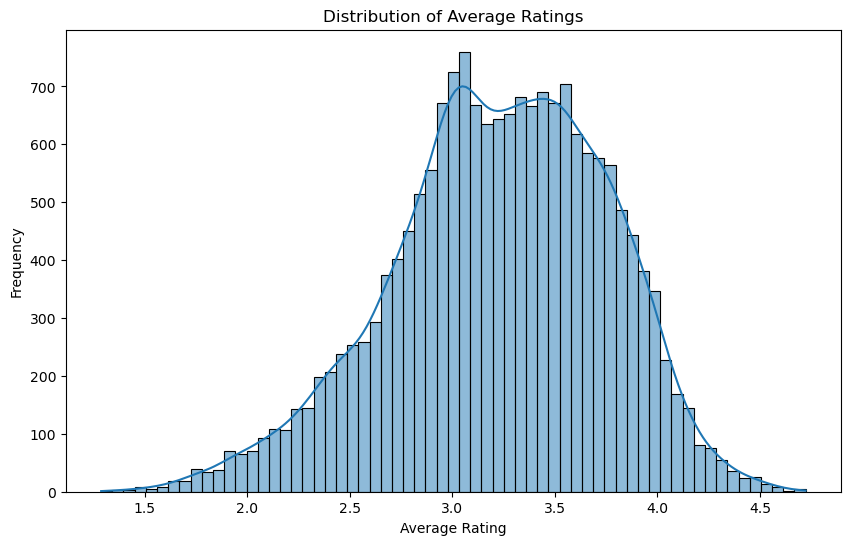

In [11]:
pandas_df = df.select('avg_rating').toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df['avg_rating'], kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


## Calculate yearly statistics

In [12]:
yearly_stats = df.groupBy('Year').agg(
    avg('avg_rating').alias('mean_rating'),
    avg('total_ratings').alias('mean_ratings_count'),
    avg('unique_users').alias('mean_unique_users')
).orderBy('Year')

In [13]:
# Convert to pandas for visualization
yearly_stats_pd = yearly_stats.toPandas()
yearly_stats_pd

,Year,mean_rating,mean_ratings_count,mean_unique_users
0,1896.0,3.677632,152.000000,152.000000
1,1909.0,2.788991,109.000000,109.000000
2,1914.0,3.016234,137.500000,137.500000
3,1915.0,3.235939,647.000000,647.000000
4,1916.0,3.431255,697.250000,697.250000
...,...,...,...,...
89,2001.0,3.126674,6116.459459,6116.459459
90,2002.0,3.143864,6596.131298,6596.131298
91,2003.0,3.234388,7534.700236,7534.700236
92,2004.0,3.230975,7281.573120,7281.573120


## Visualize Yearly Trends

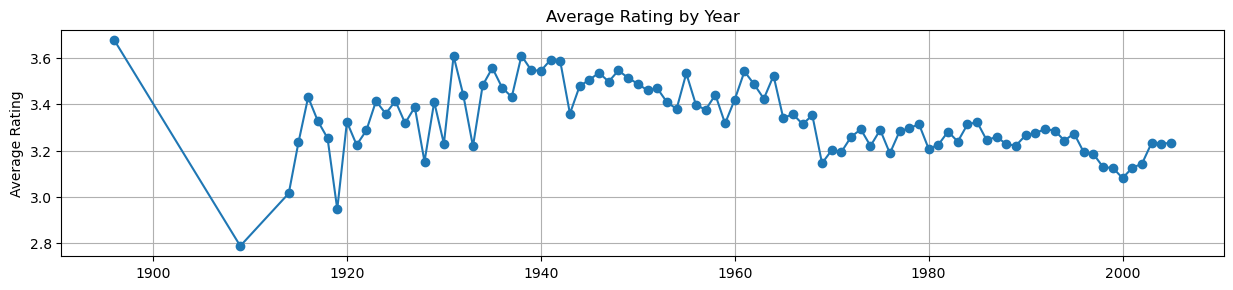

In [14]:
plt.figure(figsize=(15, 10))

# Plot 1: Average Rating by Year
plt.subplot(3, 1, 1)
plt.plot(yearly_stats_pd['Year'], yearly_stats_pd['mean_rating'], marker='o')
plt.title('Average Rating by Year')
plt.ylabel('Average Rating')
plt.grid(True)



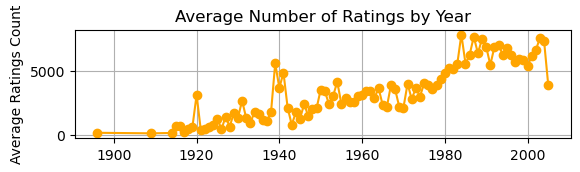

In [15]:
# Plot 2: Average Number of Ratings by Year
plt.subplot(3, 1, 2)
plt.plot(yearly_stats_pd['Year'], yearly_stats_pd['mean_ratings_count'], 
         marker='o', color='orange')
plt.title('Average Number of Ratings by Year')
plt.ylabel('Average Ratings Count')
plt.grid(True)

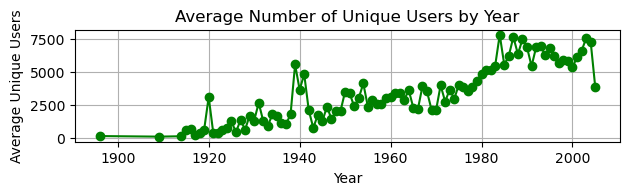

In [16]:
# Plot 3: Average Number of Unique Users by Year
plt.subplot(3, 1, 3)
plt.plot(yearly_stats_pd['Year'], yearly_stats_pd['mean_unique_users'], 
         marker='o', color='green')
plt.title('Average Number of Unique Users by Year')
plt.xlabel('Year')
plt.ylabel('Average Unique Users')
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# Prepare features
assembler = VectorAssembler(
    inputCols=['avg_rating', 'total_ratings', 'unique_users'], 
    outputCol='features'
)


In [18]:
# Scale the features
feature_df = assembler.transform(df)
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(feature_df)
scaled_df = scaler_model.transform(feature_df)

# Cell 8: Apply KMeans Clustering
# Apply KMeans clustering
kmeans = KMeans(k=5, featuresCol='scaled_features', predictionCol='cluster')
model = kmeans.fit(scaled_df)
clustered_df = model.transform(scaled_df)


24/11/28 22:37:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [19]:
# Calculate cluster statistics
cluster_stats = clustered_df.groupBy('cluster').agg(
    count('*').alias('count'),
    round(avg('avg_rating'), 2).alias('avg_rating'),
    round(avg('total_ratings'), 2).alias('avg_total_ratings'),
    round(avg('unique_users'), 2).alias('avg_unique_users')
).orderBy('cluster')

print("Cluster Analysis:")
cluster_stats.show()

Cluster Analysis:
+-------+-----+----------+-----------------+----------------+
|cluster|count|avg_rating|avg_total_ratings|avg_unique_users|
+-------+-----+----------+-----------------+----------------+
|      0| 7691|      2.75|           914.39|          914.39|
|      1|  180|      3.74|        126616.39|       126616.39|
|      2| 1061|      3.58|          26023.3|         26023.3|
|      3| 8469|      3.59|          2225.41|         2225.41|
|      4|  362|      3.67|         66846.27|        66846.27|
+-------+-----+----------+-----------------+----------------+



## Visualize Clusters

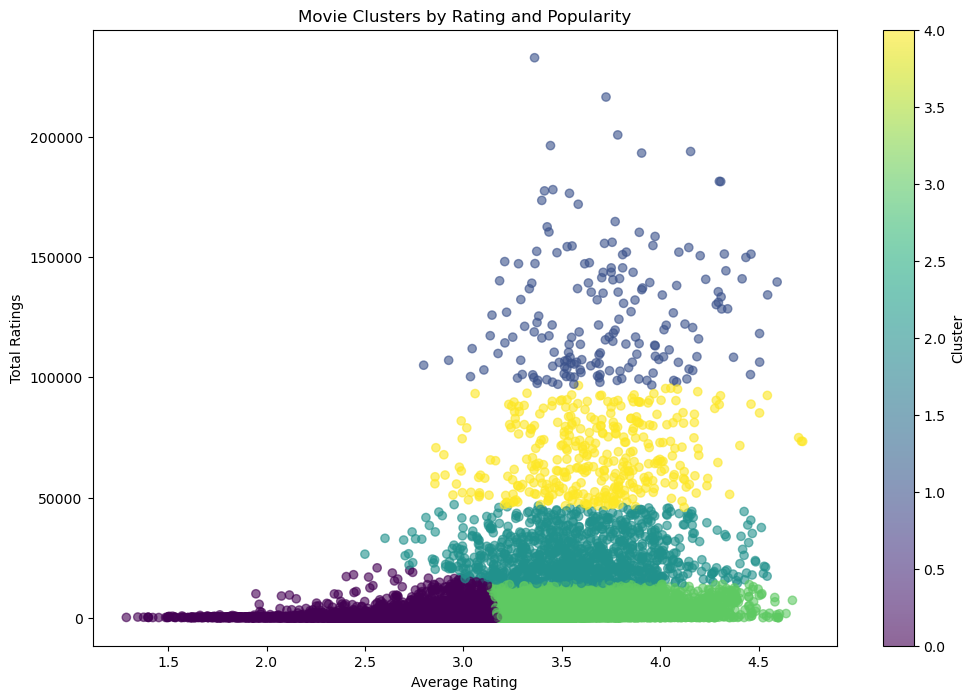

Example movies from each cluster:

Cluster 0 examples:
+------------------------------+------------------+-------------+------------+
|Title                         |avg_rating        |total_ratings|unique_users|
+------------------------------+------------------+-------------+------------+
|Look Who's Talking Now        |2.561659679051612 |20751        |20751       |
|Home Alone 2: Lost in New York|2.7270932469373292|19754        |19754       |
|Godzilla                      |2.7422412879991525|18882        |18882       |
+------------------------------+------------------+-------------+------------+


Cluster 1 examples:
+-----------------+------------------+-------------+------------+
|Title            |avg_rating        |total_ratings|unique_users|
+-----------------+------------------+-------------+------------+
|Miss Congeniality|3.361267085651487 |232944       |232944      |
|Independence Day |3.724237751389684 |216596       |216596      |
|The Patriot      |3.7838541666666665|20

In [20]:
# Convert to pandas for visualization
clusters_pd = clustered_df.select('avg_rating', 'total_ratings', 'cluster').toPandas()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clusters_pd['avg_rating'], 
                     clusters_pd['total_ratings'],
                     c=clusters_pd['cluster'],
                     cmap='viridis',
                     alpha=0.6)

plt.title('Movie Clusters by Rating and Popularity')
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cell 11: Display Example Movies from Each Cluster
print("Example movies from each cluster:")
for i in range(5):
    print(f"\nCluster {i} examples:")
    clustered_df.filter(col('cluster') == i) \
        .select('Title', 'avg_rating', 'total_ratings', 'unique_users') \
        .orderBy(desc('total_ratings')) \
        .limit(3) \
        .show(truncate=False)

In [21]:
spark.stop()